# Dataset Comparison & Validation 

This notebook aims to compare multiple datasets on solar power plants in China in order to assess their consistency, coverage, and accuracy, and to evaluate different methods used to detect or map solar installations.

The comparison process includes:
- General statistics : eg. province-level
- Visual inspection using map-based plots
- Matching quality assessment between datasets

Our goal is to assess how many installations are detected in each dataset, how they are distributed across provinces and to identify potential discrepancies or complementarities between them.

## Setup

In [25]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [65]:
import pandas as pd 
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import nearest_points
import numpy as np
import ipywidgets as widgets

## Load the Datasets 

We'll compare the following datasets:
- [GEM](https://globalenergymonitor.org/): Manual compilation of solar power plant data from public sources, reports, and satellite imagery, curated by the Global Energy Monitor (GEM) with geolocation and attribute verification.
- [PV_China_2020 (Zhang et al., 2022)](https://doi.org/10.5194/essd-14-3743-2022): Pixel-based classification of Landsat-8 imagery using a Random Forest model in Google Earth Engine, with training data from crowdsourced and manually labeled PV/non-PV regions, followed by morphological filtering and polygon vectorization.
- [ChinaPV_Vectorized_2020 (Liu et al., 2024)](https://doi.org/10.1038/s41597-024-04356-z): Random Forest classification on cloud-filtered Landsat-8 imagery enriched with texture features, refined by morphological operations and manual correction using Google Earth Pro to produce high-accuracy polygon vectors of PV installations.

We focus on the year 2020 because it is the common reference year across all three datasets. This temporal alignment ensures that our comparison is meaningful and unbiased by time-based discrepancies.

In [4]:
# Load the three datasets
gem = pd.read_csv("../../data/data_processed/GEM_processed.csv")
pvchina_2020 = gpd.read_file("../../data/data_processed/pv_china_2020.geojson")
chinapv_vectorized_2020 = gpd.read_file("../../data/data_processed/chinapv_vectorized_2020.geojson")

In [5]:
# Focus on 2020

gem_2020 = gem[
    (gem["Start year"] <= 2020) &
    (
        gem["Retired year"].isna() |
        (gem["Retired year"] >= 2020)
    )
]


## General Statistics

In [ ]:
# To effectively compare the three solar power plant datasets — GEM, PV_China_2020, and ChinaPV_Vectorized_2020 — we first identify the common columns shared by all of them. 
cols_gem = set(gem_2020.columns)
cols_pvchina = set(pvchina_2020.columns)
cols_chinapv = set(chinapv_vectorized_2020.columns)

# Find intersection (common columns)
common_columns = cols_gem.intersection(cols_pvchina).intersection(cols_chinapv)

print("Common columns across GEM, PV_China_2020, and ChinaPV_Vectorized_2020:")
print(common_columns)

Common columns across GEM, PV_China_2020, and ChinaPV_Vectorized_2020:
{'Longitude', 'Latitude', 'Province'}


In [ ]:
counts_gem = gem['Province'].value_counts().sort_index()
counts_pvchina = pvchina_2020['Province'].value_counts().sort_index()
counts_vectorized = chinapv_vectorized_2020['Province'].value_counts().sort_index()

# Combine counts into a DataFrame
province_comparison = pd.DataFrame({
    'GEM': counts_gem,
    'PV_China_2020': counts_pvchina,
    'Vectorized_2020': counts_vectorized
}).fillna(0).astype(int)

In [60]:
# Number of unique provinces covered
print("Number of unique provinces covered:")
print(f"GEM: {gem['Province'].nunique()}")
print(f"PV China 2020: {pvchina_2020['Province'].nunique()}")
print(f"Vectorized 2020: {chinapv_vectorized_2020['Province'].nunique()}")

# Distribution of installations per province (mean, median)
print("\nMean number of installations per province:")
print(province_comparison[['GEM', 'PV_China_2020', 'Vectorized_2020']].mean())

print("\nMedian number of installations per province:")
print(province_comparison[['GEM', 'PV_China_2020', 'Vectorized_2020']].median())

Number of unique provinces covered:
GEM: 31
PV China 2020: 31
Vectorized 2020: 31

Mean number of installations per province:
GEM                499.741935
PV_China_2020       81.225806
Vectorized_2020    346.322581
dtype: float64

Median number of installations per province:
GEM                446.0
PV_China_2020       58.0
Vectorized_2020    240.0
dtype: float64


Number of installations:
GEM: 8511
PV_China_2020: 2518
ChinaPV_Vectorized_2020: 10736


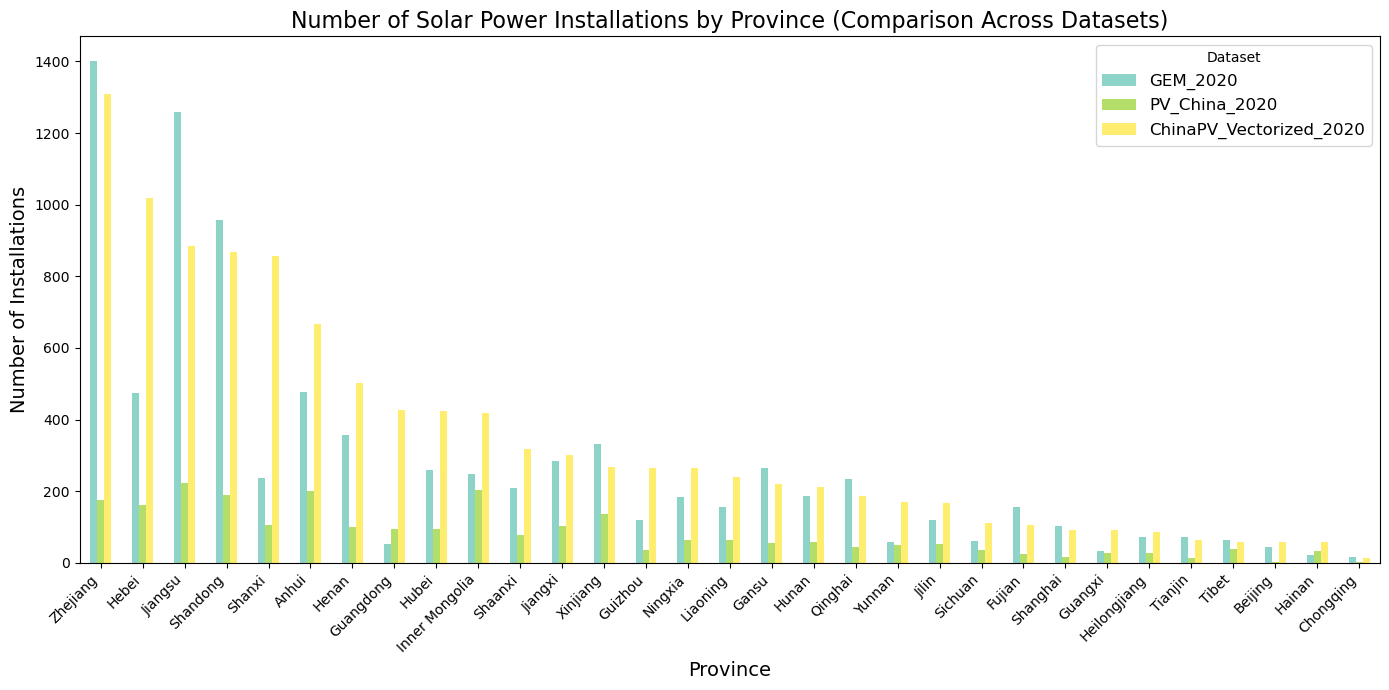

In [6]:
# Number of installations in each dataset
print("Number of installations:")
print(f"GEM: {len(gem_2020)}")
print(f"PV_China_2020: {len(pvchina_2020)}")
print(f"ChinaPV_Vectorized_2020: {len(chinapv_vectorized_2020)}")


# Count of installations by province
province_counts = {}
for df, name in zip([gem_2020, pvchina_2020, chinapv_vectorized_2020], ['GEM_2020', 'PV_China_2020', 'ChinaPV_Vectorized_2020']):
    if 'Province' in df.columns:
        province_counts[name] = df['Province'].value_counts()
        
# Combine into one DataFrame for plotting
province_df = pd.DataFrame(province_counts).fillna(0).astype(int)
province_df = province_df.loc[province_df['ChinaPV_Vectorized_2020'].sort_values(ascending=False).index]

province_df.plot(kind='bar', figsize=(14,7), colormap='Set3')

plt.title("Number of Solar Power Installations by Province (Comparison Across Datasets)", fontsize=16)
plt.ylabel("Number of Installations", fontsize=14)
plt.xlabel("Province", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Dataset", fontsize=12)
plt.tight_layout()
plt.show()


The comparison shows that the GEM and ChinaPV Vectorized 2020 datasets are quite similar in terms of the number and distribution of solar power installations across provinces, suggesting consistent coverage. In contrast, the PV_China 2020 dataset appears less comprehensive, with fewer recorded installations in many provinces. Overall, the ChinaPV Vectorized dataset seems to offer a more complete representation of solar installations in 2020.

In [ ]:
# Calculate percentage difference (example: PV_China_2020 vs GEM)
province_comparison['Ratio_GEM_to_Vectorized'] = province_comparison['GEM'] / province_comparison['Vectorized_2020'].replace(0, 1)
province_comparison['Ratio_GEM_to_PVChina'] = province_comparison['GEM'] / province_comparison['PV_China_2020'].replace(0, 1)
province_comparison['Ratio_Vectorized_to_PVChina'] = province_comparison['Vectorized_2020'] / province_comparison['PV_China_2020'].replace(0, 1)


province_comparison = province_comparison.loc[province_comparison['Vectorized_2020'].sort_values(ascending=False).index]

In [ ]:
subset_cols = [
    'Ratio_GEM_to_Vectorized',
    'Ratio_GEM_to_PVChina',
    'Ratio_Vectorized_to_PVChina'
]

def quantile_color(val, bins, colors):
    if pd.isnull(val):
        return ''
    for i, b in enumerate(bins):
        if val < b:
            return f'background-color: {colors[i]}'
    return f'background-color: {colors[-1]}'

def style_by_quantiles(df, columns, n=10):
    styled = df.style
    cmap = plt.cm.Reds
    colors = [plt.cm.colors.rgb2hex(cmap(i / n)) for i in range(n)]
    
    for col in columns:
        quantiles = df[col].quantile(np.linspace(0, 1, n + 1)).values[1:-1] 
        styled = styled.map(lambda v: quantile_color(v, quantiles, colors), subset=[col])
    return styled

styled_df = style_by_quantiles(province_comparison, subset_cols, n=10)
styled_df

,GEM,PV_China_2020,Vectorized_2020,Ratio_GEM_to_Vectorized,Ratio_GEM_to_PVChina,Ratio_Vectorized_to_PVChina
Province,,,,,,
Zhejiang,1760,176,1309,1.344538,10.000000,7.437500
Hebei,933,161,1020,0.914706,5.795031,6.335404
Jiangsu,1805,224,884,2.041855,8.058036,3.946429
Shandong,1482,190,868,1.707373,7.800000,4.568421
Shanxi,521,105,858,0.607226,4.961905,8.171429
Anhui,670,200,666,1.006006,3.350000,3.330000
Henan,468,101,502,0.932271,4.633663,4.970297
Guangdong,446,94,427,1.044496,4.744681,4.542553
Hubei,487,94,424,1.148585,5.180851,4.510638


The ratios of GEM to Vectorized are mostly close to 1, meaning these two datasets align well in many regions, while PV_China_2020 tends to have fewer records. 

## Matching data ?

How to check if the power plants are the same across the three datasets?

To answer this question, we can compare the geographic locations (latitude and longitude) of the installations across the datasets and check how many points are close enough to be considered the same plant.

Let's plot an initial map provides a general overview to visually assess whether the spatial distributions of solar power plants in the three datasets are similar or not. 

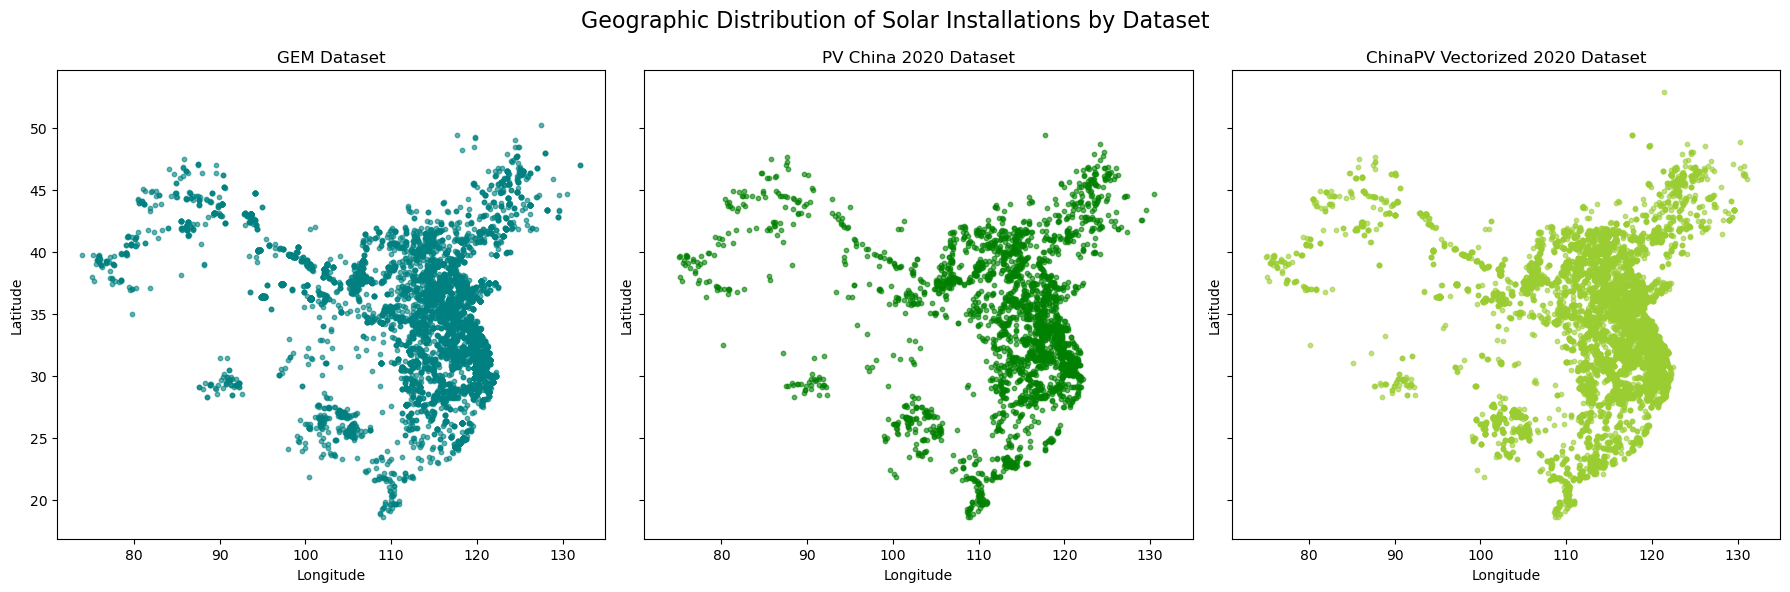

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# Plot GEM
axes[0].scatter(gem['Longitude'], gem['Latitude'], color='teal', s=10, alpha=0.6)
axes[0].set_title('GEM Dataset')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot PV China 2020
axes[1].scatter(pvchina_2020['Longitude'], pvchina_2020['Latitude'], color='green', s=10, alpha=0.6)
axes[1].set_title('PV China 2020 Dataset')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

# Plot ChinaPV Vectorized 2020
axes[2].scatter(chinapv_vectorized_2020['Longitude'], chinapv_vectorized_2020['Latitude'], color='yellowgreen', s=10, alpha=0.6)
axes[2].set_title('ChinaPV Vectorized 2020 Dataset')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')

plt.suptitle('Geographic Distribution of Solar Installations by Dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [28]:
# Function to plot selected datasets
def plot_selected(datasets):
    plt.figure(figsize=(10, 8))
    
    if 'GEM' in datasets:
        plt.scatter(gem['Longitude'], gem['Latitude'], color='teal', s=5, alpha=0.6, label='GEM')
    if 'PV China 2020' in datasets:
        plt.scatter(pvchina_2020['Longitude'], pvchina_2020['Latitude'], color='green', s=5, alpha=0.6, label='PV China 2020')
    if 'ChinaPV Vectorized 2020' in datasets:
        plt.scatter(chinapv_vectorized_2020['Longitude'], chinapv_vectorized_2020['Latitude'], color='yellowgreen', s=5, alpha=0.6, label='ChinaPV Vectorized 2020')
    
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Geographic Distribution of Solar Installations')
    plt.legend()
    plt.show()

# Create multi-select widget
dataset_selector = widgets.SelectMultiple(
    options=['GEM', 'PV China 2020', 'ChinaPV Vectorized 2020'],
    value=['GEM', 'PV China 2020', 'ChinaPV Vectorized 2020'],
    description='Datasets',
    disabled=False
)

# Link widget to plotting function
widgets.interact(plot_selected, datasets=dataset_selector);

interactive(children=(SelectMultiple(description='Datasets', index=(0, 1, 2), options=('GEM', 'PV China 2020',…

The overall spatial patterns appear quite consistent across the datasets.

Let's now we conduct a more detailed analysis to determine if the datasets actually represent the same individual installations.

#### Overlapping PV area 

In [57]:
# Reproject all datasets to same CRS for spatial operations
gem_2020 = gpd.GeoDataFrame(
    gem_2020,
    geometry=gpd.points_from_xy(gem_2020['Longitude'], gem_2020['Latitude']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

pvchina_2020 = pvchina_2020.to_crs(epsg=3857)
chinapv_vectorized_2020 = chinapv_vectorized_2020.to_crs(epsg=3857)

In [58]:
# Compute total area for each dataset (in square meters)
pvchina_2020['area'] = pvchina_2020.geometry.area
chinapv_vectorized_2020['area'] = chinapv_vectorized_2020.geometry.area

total_area_pvchina = pvchina_2020['area'].sum()
total_area_vectorized = chinapv_vectorized_2020['area'].sum()

# Compute intersection between the two datasets
overlap = gpd.overlay(pvchina_2020, chinapv_vectorized_2020, how='intersection')
overlap['overlap_area'] = overlap.geometry.area
total_overlap_area = overlap['overlap_area'].sum()

# Convert areas to km²
km2 = 1e6
print("Area Statistics (in km²):")
print(f" - Total PVChina2020 area: {total_area_pvchina / km2:.2f} km²")
print(f" - Total Vectorized2020 area: {total_area_vectorized / km2:.2f} km²")
print(f" - Total Overlap area: {total_overlap_area / km2:.2f} km²")

# Percent overlaps
percent_overlap_pvchina = (total_overlap_area / total_area_pvchina) * 100
percent_overlap_vectorized = (total_overlap_area / total_area_vectorized) * 100

print("\nOverlap Percentages:")
print(f" - % of PVChina2020 area overlapping: {percent_overlap_pvchina:.2f}%")
print(f" - % of Vectorized2020 area overlapping: {percent_overlap_vectorized:.2f}%")

# Optional: number of polygons intersecting
print(f"\nNumber of overlapping regions: {len(overlap)}")


Area Statistics (in km²):
 - Total PVChina2020 area: 4620.37 km²
 - Total Vectorized2020 area: 4510.72 km²
 - Total Overlap area: 3854.25 km²

Overlap Percentages:
 - % of PVChina2020 area overlapping: 83.42%
 - % of Vectorized2020 area overlapping: 85.45%

Number of overlapping regions: 6478


#### Check if GEM points fall inside or near PV polygons

In order to determine whether the GEM solar installations correspond to those in the PVChina2020 and Vectorized PV2020 datasets, we use a spatial proximity matching approach.  Since the GEM dataset provides only approximate point coordinates (latitude and longitude), while the other datasets represent polygons (areas) of the solar plants, we use spatial buffers around the PV polygons to account for positional uncertainty. By checking if GEM points fall within these buffered areas at different distances (e.g., 100m, 300m, 500m), we can estimate how many installations are shared across datasets, even when exact coordinates differ slightly.

In [ ]:
# Function to find nearest point in gdf_target for each point in gdf_source
def nearest_points_df(gdf_source, gdf_target):
    gdf_target_sindex = gdf_target.sindex
    nearest_geoms = []
    distances = []

    for geom in gdf_source.geometry:
        possible_matches_index = list(gdf_target_sindex.nearest(geom, 1))
        idx = possible_matches_index[0]  
        nearest_geom = gdf_target.iloc[idx].geometry
        nearest_geoms.append(nearest_geom)
        distances.append(geom.distance(nearest_geom))
    
    return distances, nearest_geoms

# Find nearest Vectorized points for each GEM point
distances_gem_vectorized, nearest_gem_vectorized = nearest_points_df(gem_2020, chinapv_vectorized_2020)

# Find nearest PVChina points for each GEM point
distances_gem_pvchina, nearest_gem_pvchina = nearest_points_df(gem_2020, pvchina_2020)

print(f"Average distance GEM to Vectorized: {np.mean(distances_gem_vectorized):.2f} meters")
print(f"Median distance GEM to Vectorized: {np.median(distances_gem_vectorized):.2f} meters")
print(f"Mininum distance GEM to Vectorized: {np.min(distances_gem_vectorized):.2f} meters")

print(f"Average distance GEM to PVChina: {np.mean(distances_gem_pvchina):.2f} meters")
print(f"Median distance GEM to PVChina: {np.median(distances_gem_pvchina):.2f} meters")
print(f"MInimum distance GEM to PVChina: {np.min(distances_gem_pvchina):.2f} meters")

Average distance GEM to Vectorized: 2045263.91 meters
Median distance GEM to Vectorized: 1889084.83 meters
Mininum distance GEM to Vectorized: 12250.48 meters
Average distance GEM to PVChina: 1008984.50 meters
Median distance GEM to PVChina: 769970.01 meters
MInimum distance GEM to PVChina: 4336.40 meters


In [20]:
# Buffer distances to test
buffer_distances = [100, 300, 500, 1000, 1500]
results = []

for threshold_m in buffer_distances:
    # Buffer PVChina
    pvchina_buffered = pvchina_2020.copy()
    pvchina_buffered['geometry'] = pvchina_buffered.geometry.buffer(threshold_m)

    # Buffer Vectorized
    vectorized_buffered = chinapv_vectorized_2020.copy()
    vectorized_buffered['geometry'] = vectorized_buffered.geometry.buffer(threshold_m)

    # Save threshold-specific columns
    gem_2020[f'match_pvchina_{threshold_m}'] = gem_2020.geometry.apply(
        lambda point: pvchina_buffered.geometry.contains(point).any()
    )
    gem_2020[f'match_vectorized_{threshold_m}'] = gem_2020.geometry.apply(
        lambda point: vectorized_buffered.geometry.contains(point).any()
    )

    match_pvchina = gem_2020[f'match_pvchina_{threshold_m}']
    match_vectorized = gem_2020[f'match_vectorized_{threshold_m}']

    match_both = match_pvchina & match_vectorized
    match_any = match_pvchina | match_vectorized
    match_only_pvchina = match_pvchina & ~match_vectorized
    match_only_vectorized = match_vectorized & ~match_pvchina

    results.append({
        'Buffer (m)': threshold_m,
        'Match PVChina_2020': match_pvchina.sum(),
        'Match ChinaPV_vectorized_2020': match_vectorized.sum(),
        'Match Both': match_both.sum(),
        'Match Any': match_any.sum(),
        'Match PVChina only': match_only_pvchina.sum(),
        'Match Vectorized only': match_only_vectorized.sum(),
        '% Match PVChina_2020': round(match_pvchina.sum() / len(gem_2020) * 100, 1),
        '% Match ChinaPV_vectorized_2020': round(match_vectorized.sum() / len(gem_2020) * 100, 1),
        '% Match Any': round(match_any.sum() / len(gem_2020) * 100, 1),
        '% Match Both': round(match_both.sum() / len(gem_2020) * 100, 1),
    })

results_df = pd.DataFrame(results)
results_df


,Buffer (m),Match PVChina_2020,Match ChinaPV_vectorized_2020,Match Both,Match Any,Match PVChina only,Match Vectorized only,% Match PVChina_2020,% Match ChinaPV_vectorized_2020,% Match Any,% Match Both
0,100,1000,1033,934,1099,66,99,11.7,12.1,12.9,11.0
1,300,1193,1224,1125,1292,68,99,14.0,14.4,15.2,13.2
2,500,1272,1338,1223,1387,49,115,14.9,15.7,16.3,14.4
3,1000,1361,1460,1319,1502,42,141,16.0,17.2,17.6,15.5
4,1500,1427,1715,1386,1756,41,329,16.8,20.2,20.6,16.3


Across all buffers, the ChinaPV vectorized dataset matches slightly more GEM points than PVChina 2020 (e.g., 1715 vs. 1427 matches at 1500m). This supports the idea that the vectorized dataset might be more complete or have larger coverage areas.

The spatial matching results indicate partial overlap but no perfect correspondence between GEM point locations and the PV polygons from the two datasets.Increasing buffer distances improves matching but does not drastically change the overall overlap  and even at the largest buffer, only about 20% of GEM points match either PV dataset’s buffered polygons. This suggests many GEM points fall outside the PV polygons or the datasets represent different subsets of installations.

In [75]:
gem_2020.head()

,Date Last Researched,Country,Project Name,Phase,Project Name in Local Language / Script,Other Name(s),Capacity (MW),Capacity Rating,Technology Type,Status,...,match_vectorized_300,match_pvchina_500,match_vectorized_500,match_pvchina_1000,match_vectorized_1000,match_pvchina_1500,match_vectorized_1500,in_pvchina,in_vectorized,category
3,2022/03/01,China,Inner Mongolia Kubuqi Desert (China Guangdong ...,1.0,中广核内蒙古库布齐沙漠朔方光伏电站,Inner Mongolia Kubuqi Shuofang solar power pla...,200.0,MWp/dc,PV,operating,...,False,False,False,False,False,False,False,False,False,none
4,2022/03/01,China,Xinjiang Alar Tianhua Sunshine Grid-Connected ...,1.0,阿拉尔天华阳光新能源新疆兵团农一师十团十一连一期30.0MW发电工程,NaN,30.0,unknown,PV,operating,...,False,False,False,False,False,False,False,False,False,none
5,2022/03/01,China,Inner Mongolia Kezuozhong Banner Beixinaile so...,1.0,科左中旗北新艾勒光伏一期（科左中旗北新艾勒一期50MWp光伏电站）,NaN,50.0,MWp/dc,PV,operating,...,True,True,True,True,True,True,True,True,True,both
7,2022/03/01,China,Xinjiang Altay Fuhai Hengcan Grid-Connected so...,1.0,新疆恒灿福海一期并网光伏发电项目,NaN,20.0,unknown,PV,operating,...,False,False,False,True,False,True,False,True,False,pvchina_only
8,2022/03/01,China,Inner Mongolia Horqin Left Rear Banner Ganqika...,1.0,国电科左后旗光伏发电通辽科尔沁左翼后旗乌兰楚鲁一期40MWp太阳能发电工程,NaN,40.0,MWp/dc,PV,operating,...,False,False,False,False,False,False,False,False,False,none


In [ ]:
threshold_dropdown = widgets.Dropdown(
    options =buffer_distances,
    value= 500,
    description='Buffer (m):',
)

colors = {
    'both': 'green',
    'pvchina_only': 'blue',
    'vectorized_only': 'red',
    'none': 'black'
}


def update_map(threshold_m):    
    # Crée les colonnes catégorie
    gem_2020['in_pvchina'] = gem_2020[f'match_pvchina_{threshold_m}']
    gem_2020['in_vectorized'] = gem_2020[f'match_vectorized_{threshold_m}']

    def categorize(row):
        if row['in_pvchina'] and row['in_vectorized']:
            return 'both'
        elif row['in_pvchina']:
            return 'pvchina_only'
        elif row['in_vectorized']:
            return 'vectorized_only'
        else:
            return 'none'

    gem_2020['category'] = gem_2020.apply(categorize, axis=1)

    fig = px.scatter_mapbox(
    gem_2020,
    lat=gem_2020.geometry.y,
    lon=gem_2020.geometry.x,
    color='category',
    color_discrete_map= colors,
    zoom=4,
    height=600,
    title="GEM points according to matching categories",
    )

    fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":30,"l":0,"b":0}
    )

    fig.show()

widgets.interact(update_map, threshold_m=threshold_dropdown)

interactive(children=(Dropdown(description='Buffer (m):', index=2, options=(100, 300, 500, 1000, 1500), value=…

<function __main__.update_map(threshold_m)>